In [ ]:
import os
import sys
import subprocess
import scanpy as sc
import pandas as pd
import numpy as np
import scipy
import matplotlib.pyplot as plt
import re
import scipy.cluster.hierarchy as spc
from pathlib import Path
import scrublet as scr
from scipy.stats import norm
import datetime
import sklearn

sc.settings.verbosity = 3  # verbosity: errors (0), warnings (1), info (2), hints (3)
sc.settings.set_figure_params(dpi=80, color_map='viridis')

plt.rcParams['figure.figsize']=(8,8)
sc.logging.print_versions()
sc.set_figure_params(facecolor="white", figsize=(15, 15))
sc.settings.verbosity = 3

# Run Scrublet

In [2]:
adata = sc.read('/nfs/team205/ig7/work_backups/backup_210306/projects/YS/YS_data/A3_V1_250721_YS_main_with_doublets_raw.h5ad')
lanes = 'lanes'

# cumulative distribution function
The cumulative distribution function of a random variable X, evaluated at x, is the probability that X will take a value less than or equal to x. Since the normal distribution is a continuous distribution, the shaded area of the curve represents the probability that X is less or equal than x. Using fill_between(x, y1, y2=0), it will fill up the area between two curves y1 and y2 which has the default value of 0.

![alt text](./cdf_form.png "Title")

# Calculating probability of value < d
$$ MAD = \text{MAD} =  M_i(|x_i-M_j(x_j)|) $$
$$ d = ((1.48 * MAD) + Median) $$
$$ \mathbb{P}(x > q) = 1 - \mathrm{CDF}_d(q) $$

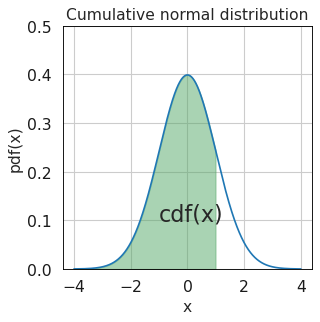

In [42]:
from scipy.stats import norm
import numpy as np
import matplotlib.pyplot as plt
fig, ax = plt.subplots()
# for distribution curve
x= np.arange(-4,4,0.001)
ax.plot(x, norm.pdf(x))
ax.set_title("Cumulative normal distribution")
ax.set_xlabel('x')
ax.set_ylabel('pdf(x)')
ax.grid(True)
# for fill_between
px=np.arange(-4,1,0.01)
ax.set_ylim(0,0.5)
ax.fill_between(px,norm.pdf(px),alpha=0.5, color='g')
# for text
ax.text(-1,0.1,"cdf(x)", fontsize=20)
plt.show()

In [36]:
def bh(pvalues):
    '''
    Computes the Benjamini-Hochberg FDR correction.

    Input:
        * pvals - vector of p-values to correct
    '''
    n = int(pvalues.shape[0])
    new_pvalues = np.empty(n)
    values = [ (pvalue, i) for i, pvalue in enumerate(pvalues) ]
    values.sort()
    values.reverse()
    new_values = []
    for i, vals in enumerate(values):
        rank = n - i
        pvalue, index = vals
        new_values.append((n/rank) * pvalue)
    for i in range(0, int(n)-1):
        if new_values[i] < new_values[i+1]:
            new_values[i+1] = new_values[i]
    for i, vals in enumerate(values):
        pvalue, index = vals
        new_pvalues[index] = new_values[i]
    return new_pvalues

####### main
scrublet_concat = pd.DataFrame(columns = ['scrublet_score','scrublet_cluster_score','bh_pval','pval'])
meta = adata.obs
sc.settings.verbosity = 1  # verbosity: errors (0), warnings (1), info (2), hints (3)
scorenames = ['scrublet_score','scrublet_cluster_score','bh_pval','pval']
###
for sample in meta[lanes].unique():
    #import data
    adata_sample = adata[adata.obs[lanes].isin([sample])]
    #rename cells to SAMPLE_BARCODE, cleaving the trailing -1
    #adata_sample.obs_names = [sample+'_'+i.split('-')[0] for i in adata_sample.obs_names]
    #set up and run Scrublet
    scrub = scr.Scrublet(adata_sample.X)
    doublet_scores, predicted_doublets = scrub.scrub_doublets(verbose=False)
    adata_sample.obs['scrublet_score'] = doublet_scores
    #overcluster prep. run turbo basic scanpy pipeline
    sc.pp.filter_cells(adata_sample, min_genes=200)
    sc.pp.filter_genes(adata_sample, min_cells=3)
    adata_sample.var['mt'] = adata_sample.var_names.str.startswith('MT-')  # annotate the group of mitochondrial genes as 'mt'
    sc.pp.calculate_qc_metrics(adata_sample, qc_vars=['mt'], percent_top=None, log1p=False, inplace=True)
    adata_sample = adata_sample[adata_sample.obs.pct_counts_mt < 20, :]
    
    sc.pp.normalize_per_cell(adata_sample, counts_per_cell_after=1e4)
    sc.pp.log1p(adata_sample)
    sc.pp.highly_variable_genes(adata_sample, min_mean=0.0125, max_mean=3, min_disp=0.5)
    adata_sample = adata_sample[:, adata_sample.var['highly_variable']]
    sc.pp.scale(adata_sample, max_value=10)
    sc.tl.pca(adata_sample, svd_solver='arpack')
    sc.pp.neighbors(adata_sample)
    
    #overclustering - do basic clustering first, then cluster each cluster
    res = 1
    key_add  = 'scrublet_leiden_R'
    key_restrict = 'scrublet_leiden'
    sc.tl.leiden(adata_sample,key_added= 'scrublet_leiden')
    adata_sample.obs[key_add] = adata_sample.obs[key_restrict]
    for clus in adata_sample.obs[key_add].unique():
        sc.tl.leiden(adata_sample, resolution= 1,key_added=key_add, random_state=26, n_iterations=-1, restrict_to=[key_add, [clus]])
        adata_sample.obs[key_add] = adata_sample.obs[key_add].astype('str')
        adata_sample.obs[key_add] = (adata_sample.obs[key_add].replace({',':'_'}, regex=True))
        adata_sample.obs[key_add] = adata_sample.obs[key_add].astype('category')

    #compute the cluster scores - the median of Scrublet scores per overclustered cluster
    #adata_sample.obs['scrublet_leiden_R'] = adata_sample.obs['scrublet_leiden_R'].astype(str)
    adata_sample.obs['scrublet_cluster_score'] = adata_sample.obs['scrublet_cluster_score'].astype(float)
    for clus in np.unique(adata_sample.obs['scrublet_leiden_R']):
        adata_sample.obs.loc[adata_sample.obs['scrublet_leiden_R']==clus, 'scrublet_cluster_score'] = np.median(adata_sample.obs.loc[adata_sample.obs['scrublet_leiden_R']==clus, 'scrublet_score'])
    #now compute doublet p-values. figure out the median and mad (from above-median values) for the distribution
    #scr_clust_score = adata_sample.obs['scrublet_cluster_score'].unique()
    #med = np.median(adata_sample.obs['scrublet_cluster_score'])
    #mask = adata_sample.obs['scrublet_cluster_score']>med
    #mad = np.median(adata_sample.obs['scrublet_cluster_score'][mask]-med)
    scr_clust_score = adata_sample.obs['scrublet_cluster_score'].unique()
    med = np.median(scr_clust_score )
    mask = scr_clust_score>med
    mad = np.median(scr_clust_score [mask]-med)
    
    #let's do a one-sided test. the Bertie write-up does not address this but it makes sense, Cumulative Distribution Function
    #pvals = 1-scipy.stats.norm.cdf(adata_sample.obs['scrublet_cluster_score'], loc=med, scale=2*mad)
    pvals = 1-scipy.stats.norm.cdf(adata_sample.obs['scrublet_cluster_score'], loc=med, scale=1.4826*mad) #1.4826*mad
    #Introduce BH correction per cluster instead of by cell
    adata_sample.obs['bh_pval'] = bh(pvals)
    adata_sample.obs['pval'] = pvals
    
    #create results data frame for single sample and copy stuff over from the adata object
    scrublet_sample = pd.DataFrame(0, index=adata_sample.obs_names, columns=scorenames)
    for meta in scorenames:
        scrublet_sample[meta] = adata_sample.obs[meta]
    #write out complete sample scores
    scrublet_sample.to_csv("./scrublet_scores/"+sample+'.csv')
    scrublet_concat = pd.concat([scrublet_concat,scrublet_sample])
scrublet_concat.to_csv('./combined_scrublet_scores.csv')

/home/jovyan/my-conda-envs/workhorse/lib/python3.8/site-packages/pandas/core/arrays/categorical.py:2487: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  res = method(*args, **kwargs)
Trying to set attribute `.obs` of view, copying.
/home/jovyan/my-conda-envs/workhorse/lib/python3.8/site-packages/pandas/core/arrays/categorical.py:2487: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  res = method(*args, **kwargs)
/home/jovyan/my-conda-envs/workhorse/lib/python3.8/site-packages/pandas/core/arrays/categorical.py:2487: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  res = method(*args, **kwargs)
/home/jovyan/my-conda-envs/workhorse/lib/python3.8/site-packages/scanpy/preprocessing/_simple.py:845: UserWarning: Re

In [6]:
scrublet_concat

,scrublet_score,scrublet_cluster_score,bh_pval,pval
Cell_dat_Yolksac_Cell_dat_Yolksac_AAACCTGAGACCTTTG_1,0.050505,0.032988,0.827829,0.827829
Cell_dat_Yolksac_Cell_dat_Yolksac_AAACCTGCACCTATCC_1,0.023729,0.062035,0.802789,0.474026
Cell_dat_Yolksac_Cell_dat_Yolksac_AAACCTGCACTTAAGC_1,0.030137,0.036027,0.827829,0.799505
Cell_dat_Yolksac_Cell_dat_Yolksac_AAACCTGGTAACGACG_1,0.312977,0.142857,0.016309,0.002004
Cell_dat_Yolksac_Cell_dat_Yolksac_AAACCTGGTCAAAGAT_1,0.040984,0.064639,0.802789,0.438107
...,...,...,...,...
F80_Yolksac_Hep_FCAImmP8096696_TTTGGTTCATCCGTGG,0.024336,0.024336,0.740693,0.731247
F80_Yolksac_Hep_FCAImmP8096696_TTTGTCAAGATGCCAG,0.043597,0.074468,0.740693,0.371784
F80_Yolksac_Hep_FCAImmP8096696_TTTGTCAGTCGAACAG,0.078611,0.074468,0.740693,0.371784
F80_Yolksac_Hep_FCAImmP8096696_TTTGTCATCATTCACT,0.017189,0.022801,0.740693,0.740693


In [42]:
adata.obs['scr_bh_pval']

Cell_dat_Yolksac_Cell_dat_Yolksac_AAACCTGAGACCTTTG_1    0.827829
Cell_dat_Yolksac_Cell_dat_Yolksac_AAACCTGCACCTATCC_1    0.802789
Cell_dat_Yolksac_Cell_dat_Yolksac_AAACCTGCACTTAAGC_1    0.827829
Cell_dat_Yolksac_Cell_dat_Yolksac_AAACCTGGTAACGACG_1    0.016309
Cell_dat_Yolksac_Cell_dat_Yolksac_AAACCTGGTCAAAGAT_1    0.802789
                                                          ...   
F80_Yolksac_Hep_FCAImmP8096696_TTTGGTTCATCCGTGG         0.740693
F80_Yolksac_Hep_FCAImmP8096696_TTTGTCAAGATGCCAG         0.740693
F80_Yolksac_Hep_FCAImmP8096696_TTTGTCAGTCGAACAG         0.740693
F80_Yolksac_Hep_FCAImmP8096696_TTTGTCATCATTCACT         0.740693
F80_Yolksac_Hep_FCAImmP8096696_TTTGTCATCGGATGGA         0.740693
Name: scr_bh_pval, Length: 136540, dtype: float64

In [7]:
adata.obs[['scrublet_score','scrublet_cluster_score','scr_bh_pval','scr_pval']] = ''
adata.obs[['scrublet_score','scrublet_cluster_score','scr_bh_pval','scr_pval']] = scrublet_concat[['scrublet_score','scrublet_cluster_score','bh_pval','pval']]
#adata.obs = adata.obs.drop(columns = ['lr_batch', 'corr_concat','res_30', 'LouvainClustering', 'fullmeta', 'short_code','oldanno','Hep', 'oldanno_2', 'Component','cell_labels_back_050820',
#       'subcluster_annotation_back_050820', 'refined_cell_label_back_050820',
#       '160920_cell_labels', '160920_subclusters', '160920_broad_cell_labels', '301020_microglia_assignment',
#       'restricted_301020_microglia_assignment',
#       'predicted_301020_microglia_assignment', 'lvl_1_cell.labels',
#       'lvl_2_cell.labels', 'cell_labels', 'broad_cell_labels', 'batch','cell.labels_back_010721',  'num', 'predicted_num',
#       'clus_predicted_num','cell.labels_back_100721','annot_clus_prediction_concat',  'assigned_clus_prediction'])
#adata.write('/nfs/team205/ig7/work_backups/backup_210306/projects/YS/YS_data/A3_V1_250721_YS_main_with_doublets_raw.h5ad')

In [8]:
adata.obs.loc[adata.obs['scr_bh_pval'] < 0.05]

,cell.labels,age,stage,fetal_ids,stages,tissue,lanes,corr_concat,n_genes,n_counts,...,predicted_301020_microglia_assignment,lvl_1_cell.labels,lvl_2_cell.labels,cell_labels,broad_cell_labels,batch,scr_bh_pval,scr_pval,new_doublets,new_doublets_bh
Cell_dat_Yolksac_Cell_dat_Yolksac_AAACCTGGTAACGACG_1,Ery,4WPC,CS10,CS10_cell,CS10,yolksac,CS10_cell,Ery_NEW,nan,nan,...,nan,nan,nan,nan,nan,0,0.016309,0.002004,True,True
Cell_dat_Yolksac_Cell_dat_Yolksac_AAACGGGCAGGATCGA_1,Ery,4WPC,CS10,CS10_cell,CS10,yolksac,CS10_cell,Ery_NEW,nan,nan,...,nan,nan,nan,nan,nan,0,0.016309,0.002004,True,True
Cell_dat_Yolksac_Cell_dat_Yolksac_AAACGGGTCCTGTAGA_1,Ery,4WPC,CS10,CS10_cell,CS10,yolksac,CS10_cell,Ery_NEW,nan,nan,...,nan,nan,nan,nan,nan,0,0.016309,0.002004,True,True
Cell_dat_Yolksac_Cell_dat_Yolksac_AAAGCAATCTAACTTC_1,Ery,4WPC,CS10,CS10_cell,CS10,yolksac,CS10_cell,Ery_NEW,nan,nan,...,nan,nan,nan,nan,nan,0,0.016309,0.002004,True,True
Cell_dat_Yolksac_Cell_dat_Yolksac_AACACGTAGTGTTTGC_1,Ery,4WPC,CS10,CS10_cell,CS10,yolksac,CS10_cell,Ery_NEW,nan,nan,...,nan,nan,nan,nan,nan,0,0.016309,0.002004,True,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
F80_Yolksac_45N_FCAImmP8096695_TGTGGTACACAGCCCA,Fibroblast,nan,nan,F80,CS15,yolkSac,FCAImmP8096695,Fibroblast_YS,2714,3764.987060546875,...,Fibroblast,Fibroblast,Fibroblast,Fibroblast,Fibroblast,1,0.000000,0.000000,True,True
F80_Yolksac_45N_FCAImmP8096695_TTAACTCTCAGAGACG,Fibroblast,nan,nan,F80,CS15,yolkSac,FCAImmP8096695,Fibroblast_YS,912,2212.32275390625,...,Fibroblast,Fibroblast,Fibroblast,Fibroblast,Fibroblast,1,0.000000,0.000000,True,True
F80_Yolksac_45N_FCAImmP8096695_TTCGGTCCATGCCCGA,Fibroblast,nan,nan,F80,CS15,yolkSac,FCAImmP8096695,Fibroblast_YS,1961,3273.806884765625,...,Fibroblast,Fibroblast,Fibroblast,Fibroblast,Fibroblast,1,0.000000,0.000000,True,True
F80_Yolksac_45N_FCAImmP8096695_TTGACTTAGAAACCTA,Fibroblast,nan,nan,F80,CS15,yolkSac,FCAImmP8096695,Fibroblast_YS,2370,3541.49462890625,...,Fibroblast,Fibroblast,Fibroblast,Fibroblast,Fibroblast,1,0.000000,0.000000,True,True


In [53]:
adata.obs.columns

Index(['cell.labels', 'age', 'stage', 'fetal_ids', 'stages', 'tissue', 'lanes',
       'corr_concat', 'n_genes', 'n_counts', 'orig_ident', 'percent_mito',
       'sort_ids', 'sample_type', 'gender', 'AnnatomicalPart', 'res_30',
       'LouvainClustering', 'fullmeta', 'short_code', 'scrublet_score',
       'scrublet_cluster_score', 'bh_pval', 'oldanno', 'leiden', 'leiden_sub',
       'Hep', 'oldanno_2', 'Component', 'refined_cell_labels', 'predicted',
       'cell_labels_back_050820', 'subcluster_annotation_back_050820',
       'refined_cell_label_back_050820', '160920_cell_labels',
       '160920_subclusters', '160920_broad_cell_labels', 'broad_cell_label',
       '301020_microglia_assignment', 'restricted_301020_microglia_assignment',
       'predicted_301020_microglia_assignment', 'lvl_1_cell.labels',
       'lvl_2_cell.labels', 'cell_labels', 'broad_cell_labels', 'batch',
       'scr_bh_pval', 'scr_pval', 'new_doublets', 'new_doublets_bh'],
      dtype='object')

In [ ]:
# Doublet Rate
len(list(adata.obs.index[adata.obs['new_doublets']=='True']))
print('doublet rate = ' + str((len(list(adata.obs.index[adata.obs['new_doublets']=='True'])) / len(adata.obs))*100) + '%')